In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.cosmology
import scipy.stats
import time
from useful_funcs import PAUSflux_to_ABmag
import h5py
import matplotlib.colors
import os
from SAVEFIG import main as custom_SAVEFIG

latex_textwidth = 455.24#pt

def fixed_aspect_ratio(ratio):
    '''
    Set a fixed aspect ratio on matplotlib plots 
    regardless of axis units
    '''
    xvals,yvals = plt.gca().axes.get_xlim(),plt.gca().axes.get_ylim()

    xrange = xvals[1]-xvals[0]
    yrange = yvals[1]-yvals[0]
    plt.gca().set_aspect(ratio*(xrange/yrange), adjustable='box')

#matplotlib.rcParams['agg.path.chunksize'] = 10000

In [2]:
from astropy.cosmology import Planck15 as cosmo

cosmo = cosmo.clone(name='Planck15 H0 = 100', H0=100) #setting H0 = 100 km/s/MPc, h = 1


In [3]:
data = pd.read_pickle("../../Data/Object_zs_zp_181203_130401.pkl.gz")


# lcCoreFilename = "Gonzalez13.PAU.MillGas.field1.core.0.hdf5"
# lcPhotomFilename = "Gonzalez13.PAU.MillGas.field1.photometry.0.hdf5"

# if os.environ['NAME'] == 'DESKTOP-RB5C8OC': 
#     file_path = '/mnt/e/L4ProjectLocal/LightConeData/'
# elif os.environ['NAME'] == 'LaNaranjaDos':
#     file_path = '/mnt/c/Users/Andrew/L4ProjectLocal/Light Cone Data/'
# else: raise Exception('Device not configured for hdf5 data load')

# LC_DATA_CORE = h5py.File(file_path+lcCoreFilename, "r")
# LC_DATA_PHOTOM = h5py.File(file_path+lcPhotomFilename, "r")

In [4]:
def ub68(x):
    return np.percentile(x,50+34.1)

def lb68(x):
    return np.percentile(x,50-34.1)

In [5]:
r1, g1, b1 = 255, 235, 247
r1, g1, b1 = r1/255, g1/255, b1/255

cdict1 = {'red':   ((0.0, r1, r1),
                   (1.0, 0.75, 0.75)),

         'green': ((0.0, g1, g1),
                   (1.0, 0.04, 0.04)),

         'blue':  ((0.0, b1, b1),
                   (1.0, 0.4, 0.4)),
          
         'alpha': ((0.0, 0.0, 0.0),
                   (1e-20, 1.0, 1.0),
                    (1.0, 1.0, 1.0))
        }

clear_purple = matplotlib.colors.LinearSegmentedColormap('ClearPurple', cdict1)
plt.register_cmap(cmap=clear_purple)

# ANNz run performace (PAUS_advanced14, ANN)

In [6]:
ML_DATA = pd.read_csv('../../ML runs/PAUS_advanced14/ANNZ_randomReg_0002.csv',header=0)
N_points = 500
indices = np.random.choice(ML_DATA.shape[0],N_points,replace=False)
z_annz = ML_DATA['F:ANNZ_best']
z_paus = ML_DATA['F:zb']
z_annz_errors = ML_DATA['F:ANNZ_best_err']
# z_annz_errors = ML_DATA['F:ANNZ_best_err']

# ML_input = pd.read_csv('../../Data/ANNz_data5b.csv',header=0)

error = z_annz - z_paus
normed_error = error / (1+z_paus)

outliers_idx = abs(normed_error) > 0.15
out_perc = outliers_idx.sum()/outliers_idx.size *100

print("\
Mean normed error                             = {:1.2e} \n\
st. dev of normed error                       = {:.3f}\n\
Percentage of 'catastrophic' outliers         = {:.3f}%\n\
half width of 68th percentile of normed error = {:.3f}"\
.format(normed_error.mean(),np.std(normed_error),out_perc,(ub68(normed_error)-lb68(normed_error))/2))

Mean normed error                             = 3.45e-03 
st. dev of normed error                       = 0.141
Percentage of 'catastrophic' outliers         = 1.247%
half width of 68th percentile of normed error = 0.023


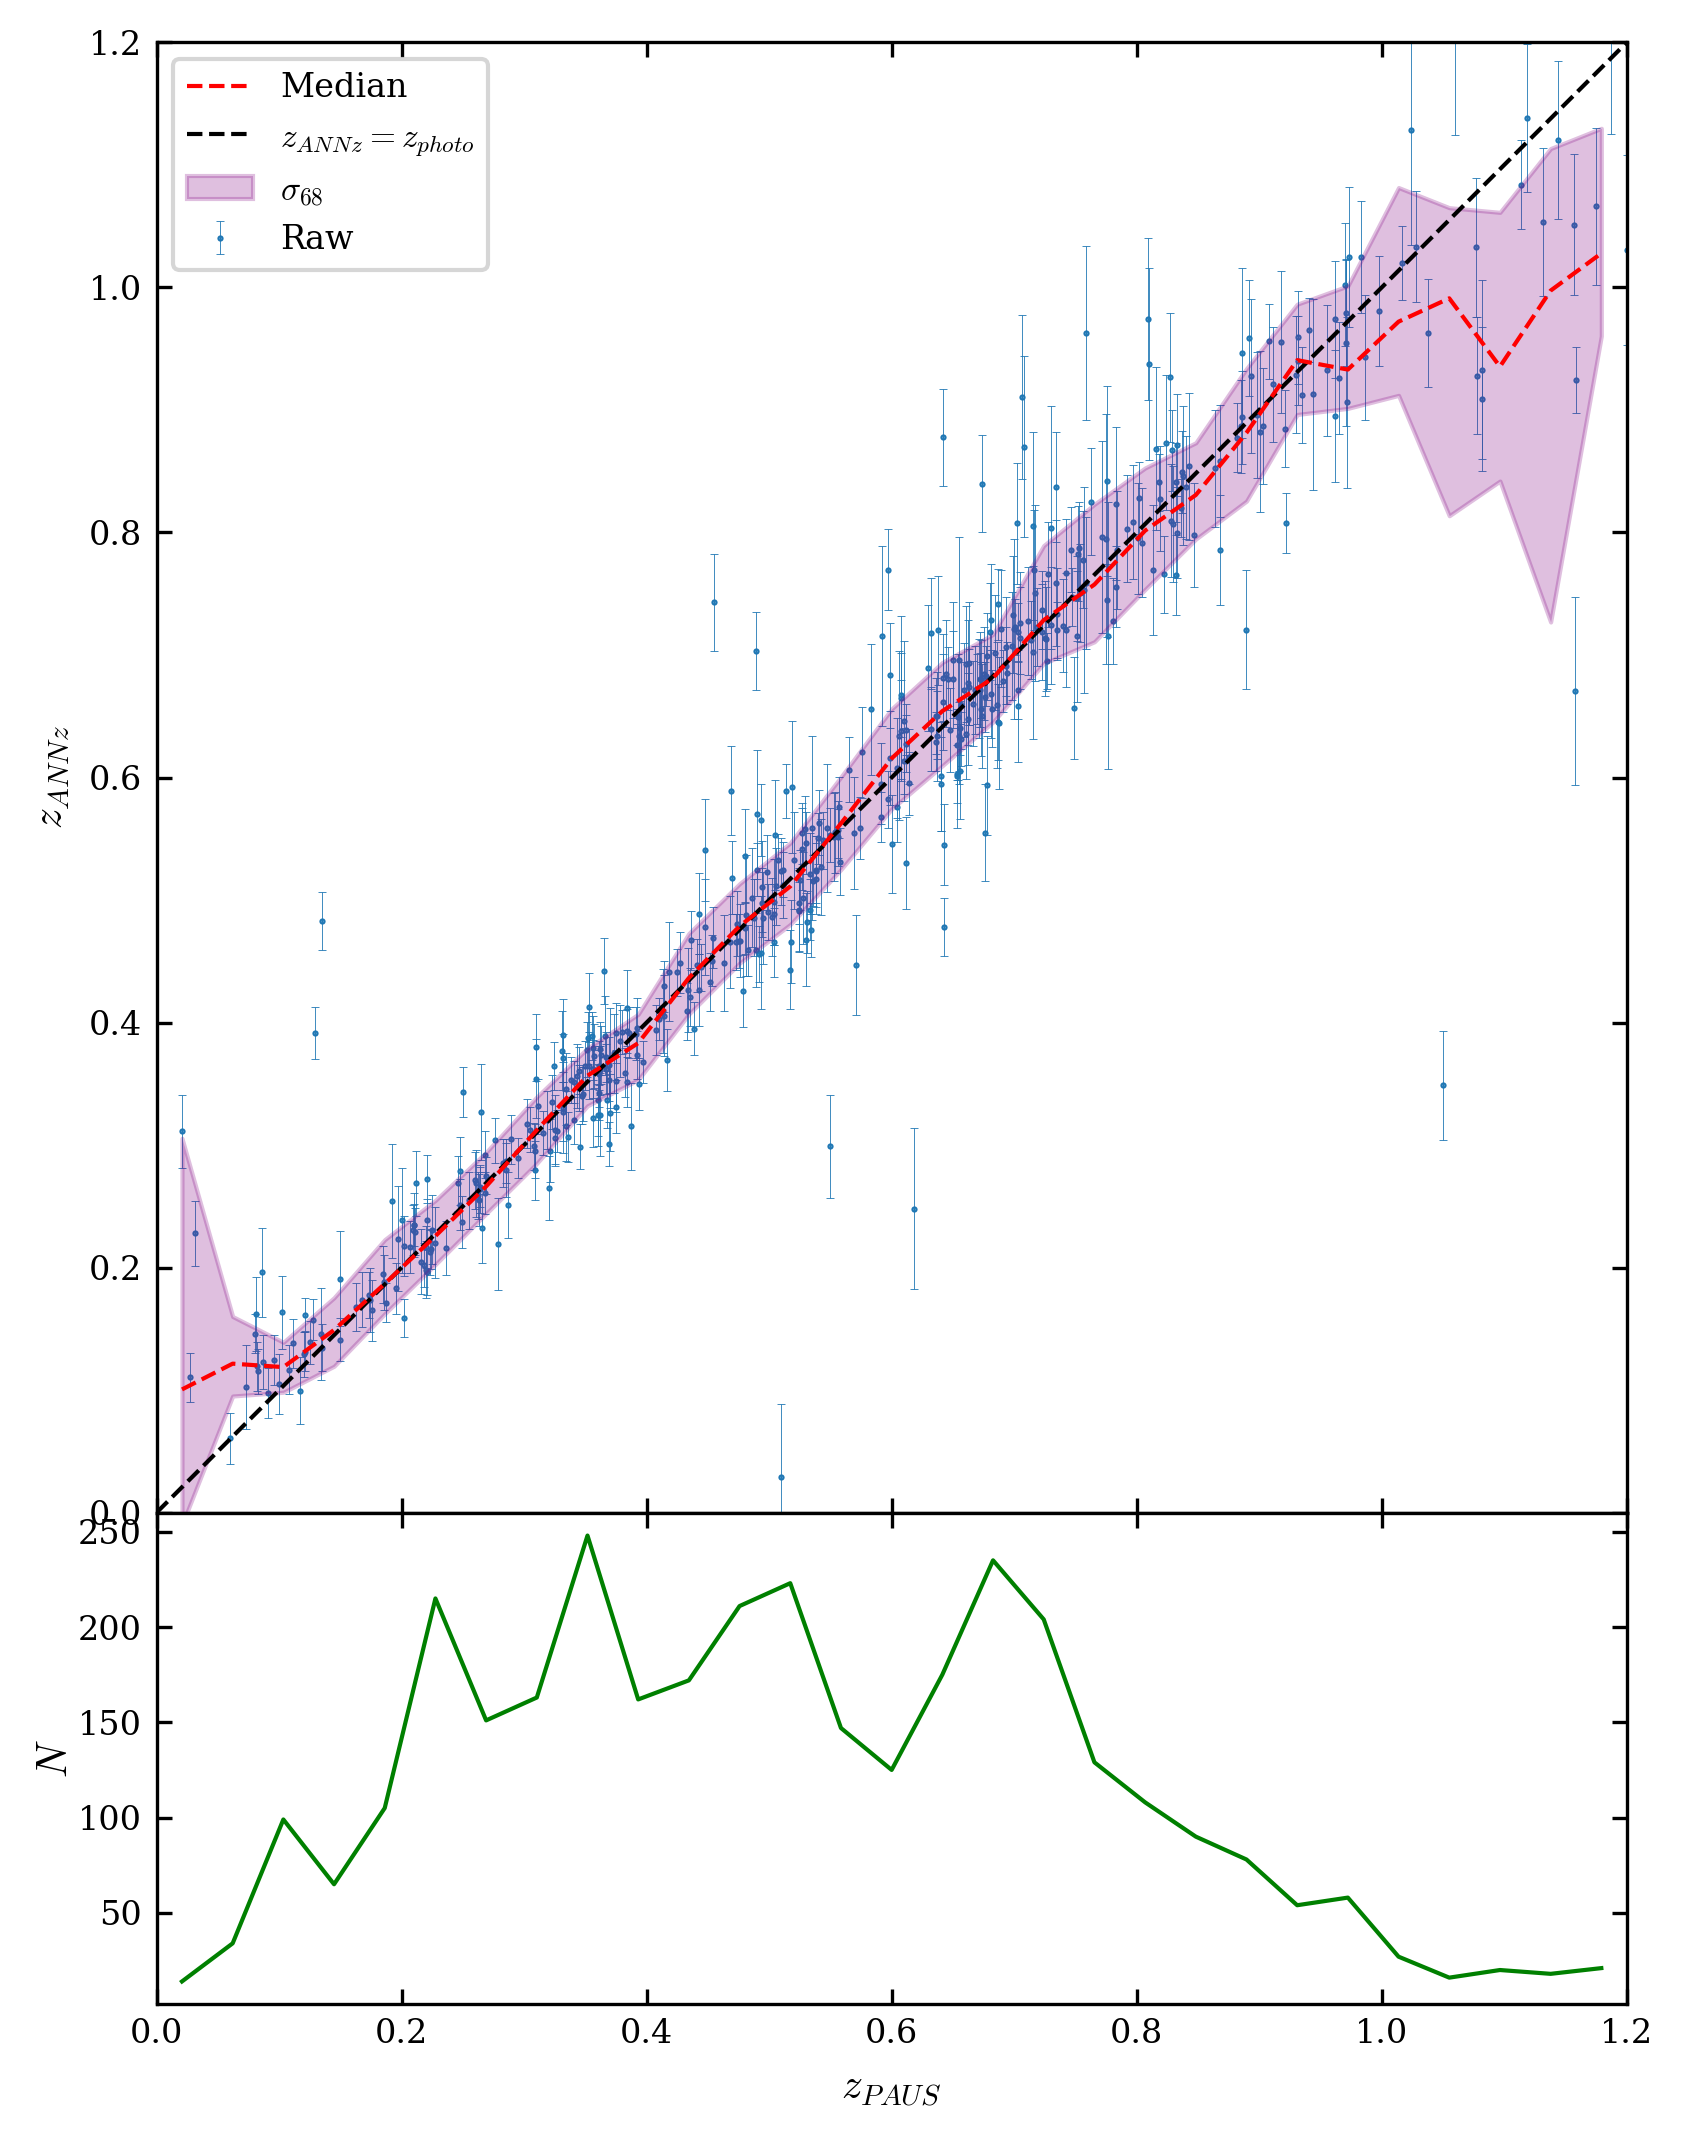

In [7]:
# ML_DATA = pd.read_csv('../../ML runs/PAUS_advanced3/regres/eval_nFile0/ANNZ_randomReg_0000.csv',header=0)
# ML_DATA
# print(ML_DATA.shape)
N_points = 250
# indices = np.random.choice(ML_DATA.shape[0],N_points,replace=False)

min_bin, max_bin, N_bin = 0.0,1.2,30
bins = np.linspace(min_bin, max_bin, N_bin)
meds,edge,counts = scipy.stats.binned_statistic(z_paus,z_annz,'median',bins=bins)
lbs = scipy.stats.binned_statistic(z_paus,z_annz,lb68,bins)[0]
ubs = scipy.stats.binned_statistic(z_paus,z_annz,ub68,bins)[0]


factor = latex_textwidth/72#*0.5
# fig = plt.figure(figsize=(factor*1.2,factor),dpi=300)
fig, (ax1,ax2) = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3, 1]},figsize=(1*factor,1.37*factor),dpi=300,sharex=True)

ax1.errorbar(z_paus.loc[indices],z_annz.loc[indices],yerr=z_annz_errors.loc[indices]\
             ,fmt='o',ms=0.5,linewidth=0.2,capsize=1,capthick=0.2,label='Raw'.format(N_points),zorder=1)
ax1.plot((bins[:-1]+bins[1:])/2,meds,'r--',label='Median',zorder=5,linewidth=1)
ax1.plot([0,1.2],[0,1.2],'k--',label=r'$z_{ANNz}=z_{photo}$',zorder=4,linewidth=1)
ax1.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.25,zorder=3,label=r'$\sigma_{68}$',color='purple')
ax2.set_xlabel(r'$z_{PAUS}$')
ax1.set_ylabel(r'$z_{ANNz}$')
ax1.legend(fontsize=8)
ax1.set_xlim(0.0,1.2)
ax1.set_ylim(0.0,1.2)
ax1.set_aspect('equal')

# ax2 = plt.subplot(212)
unique, counted = np.unique(counts, return_counts=True)
# print(unique,'\n',counted)
# ax2.plot((bins[:-1]+bins[1:])/2,counted/(max_bin-min_bin)*N_bin,'g-',zorder=5,linewidth=1)
# ax2.set_ylabel('$n$') #object density
ax2.plot((bins[:-1]+bins[1:])/2,counted,'g-',zorder=5,linewidth=1)
ax2.set_ylabel('$N$')
ax2.yaxis.labelpad=0.5


fig.subplots_adjust(hspace=0)
# custom_SAVEFIG('ML')

plt.show()

# ANNz run performace (PAUS_advanced17, ANN & BDT)

In [8]:
ML_DATA = pd.read_csv('../../ML runs/PAUS_advanced17/ANNZ_randomReg_0000.csv',header=0)
z_annz = ML_DATA['F:ANNZ_best']
z_paus = ML_DATA['F:zb']
z_annz_errors = ML_DATA['F:ANNZ_best_err']
# z_annz_errors = ML_DATA['F:ANNZ_best_err']

# ML_input = pd.read_csv('../../Data/ANNz_data5b.csv',header=0)

error = z_annz - z_paus
normed_error = error / (1+z_paus)

outliers_idx = abs(normed_error) > 0.15
out_perc = outliers_idx.sum()/outliers_idx.size *100

print("\
Mean normed error                             = {:1.2e} \n\
st. dev of normed error                       = {:.3f}\n\
Percentage of 'catastrophic' outliers         = {:.3f}%\n\
half width of 68th percentile of normed error = {:.3f}"\
.format(normed_error.mean(),np.std(normed_error),out_perc,(ub68(normed_error)-lb68(normed_error))/2))

Mean normed error                             = 4.82e-03 
st. dev of normed error                       = 0.097
Percentage of 'catastrophic' outliers         = 9.415%
half width of 68th percentile of normed error = 0.068


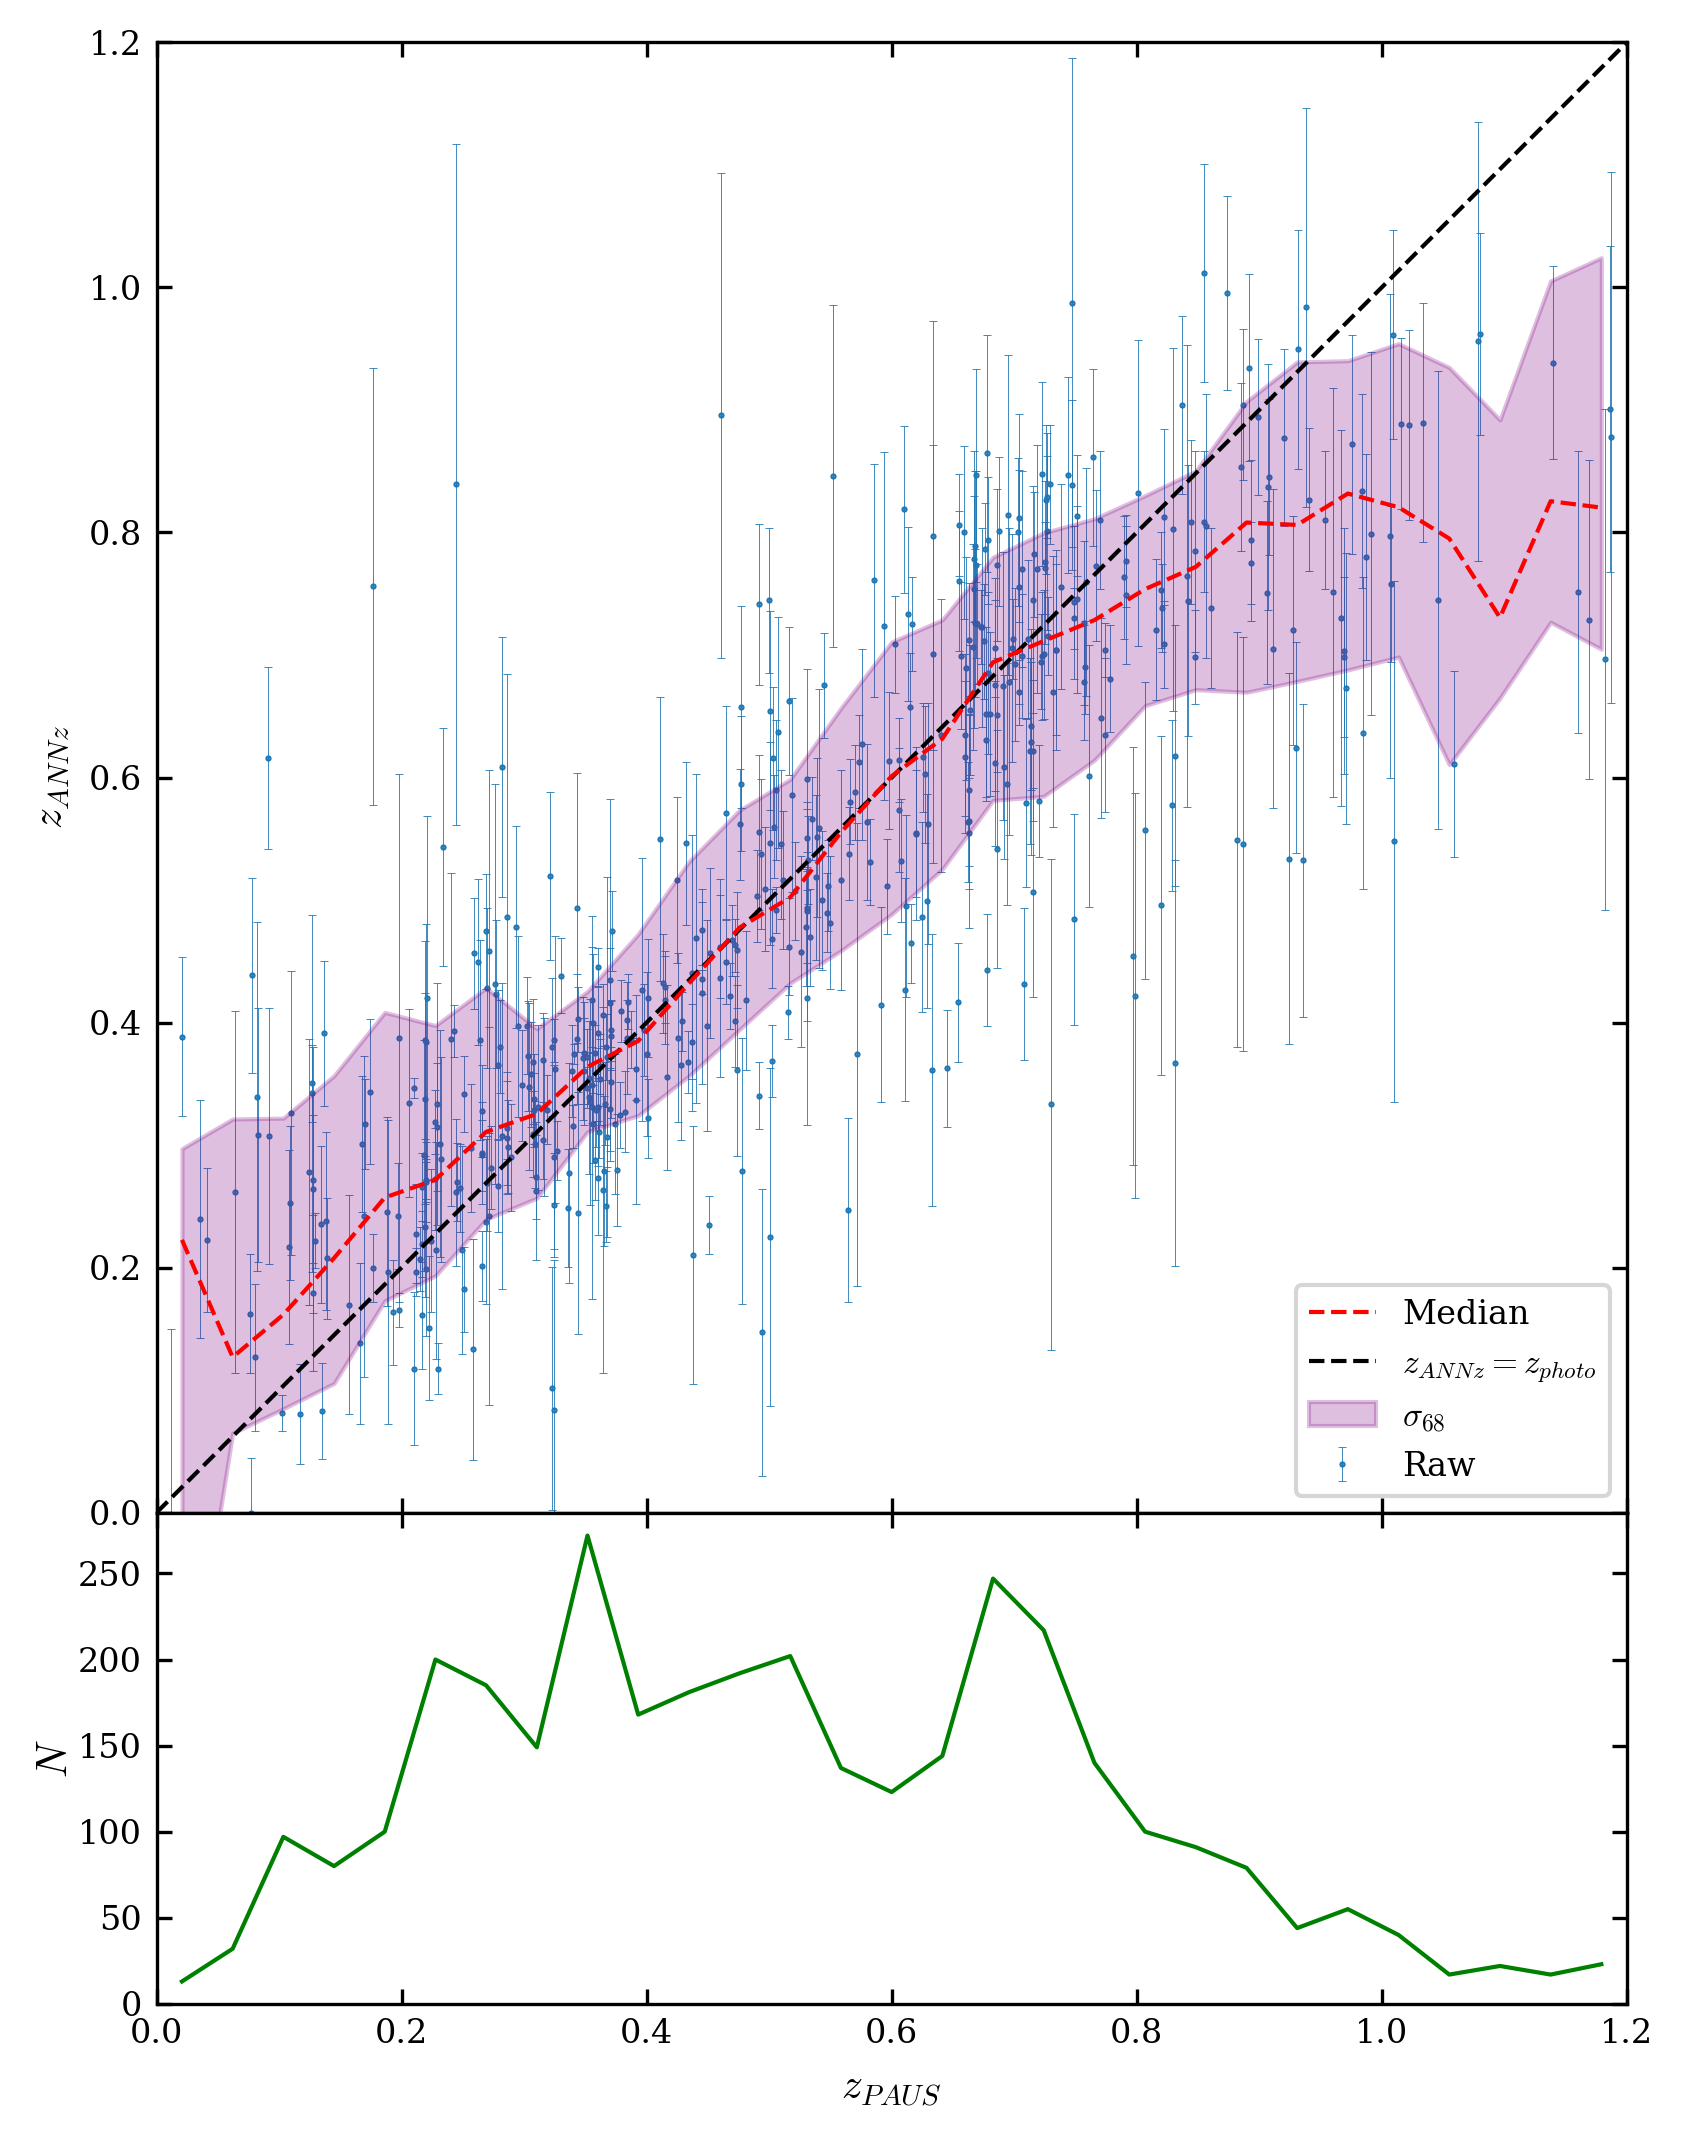

In [9]:
# ML_DATA = pd.read_csv('../../ML runs/PAUS_advanced3/regres/eval_nFile0/ANNZ_randomReg_0000.csv',header=0)
# ML_DATA
# print(ML_DATA.shape)
N_points = 250
# indices = np.random.choice(ML_DATA.shape[0],N_points,replace=False)

min_bin, max_bin, N_bin = 0.0,1.2,30
bins = np.linspace(min_bin, max_bin, N_bin)
meds,edge,counts = scipy.stats.binned_statistic(z_paus,z_annz,'median',bins=bins)
lbs = scipy.stats.binned_statistic(z_paus,z_annz,lb68,bins)[0]
ubs = scipy.stats.binned_statistic(z_paus,z_annz,ub68,bins)[0]


factor = latex_textwidth/72#*0.5
# fig = plt.figure(figsize=(factor*1.2,factor),dpi=300)
fig, (ax1,ax2) = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3, 1]},figsize=(1*factor,1.37*factor),dpi=300,sharex=True)

ax1.errorbar(z_paus.loc[indices],z_annz.loc[indices],yerr=z_annz_errors.loc[indices]\
             ,fmt='o',ms=0.5,linewidth=0.2,capsize=1,capthick=0.2,label='Raw'.format(N_points),zorder=1)
ax1.plot((bins[:-1]+bins[1:])/2,meds,'r--',label='Median',zorder=5,linewidth=1)
ax1.plot([0,1.2],[0,1.2],'k--',label=r'$z_{ANNz}=z_{photo}$',zorder=4,linewidth=1)
ax1.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.25,zorder=3,label=r'$\sigma_{68}$',color='purple')
ax2.set_xlabel(r'$z_{PAUS}$')
ax1.set_ylabel(r'$z_{ANNz}$')
ax1.legend(fontsize=8)
ax1.set_xlim(0.0,1.2)
ax1.set_ylim(0.0,1.2)
ax1.set_aspect('equal')

# ax2 = plt.subplot(212)
unique, counted = np.unique(counts, return_counts=True)
# print(unique,'\n',counted)
# ax2.plot((bins[:-1]+bins[1:])/2,counted/(max_bin-min_bin)*N_bin,'g-',zorder=5,linewidth=1)
# ax2.set_ylabel('$n$') #object density
ax2.plot((bins[:-1]+bins[1:])/2,counted,'g-',zorder=5,linewidth=1)
ax2.set_ylabel('$N$')
ax2.yaxis.labelpad=0.5


fig.subplots_adjust(hspace=0)
# custom_SAVEFIG('ML')

plt.show()

# ANNz run performace (PAUS_advanced18, ANN & BDT)

In [10]:
ML_DATA = pd.read_csv('../../ML runs/PAUS_advanced18/ANNZ_randomReg_0001.csv',header=0)
z_annz = ML_DATA['F:ANNZ_best']
z_paus = ML_DATA['F:zb']
z_annz_errors = ML_DATA['F:ANNZ_best_err']
# z_annz_errors = ML_DATA['F:ANNZ_best_err']

# ML_input = pd.read_csv('../../Data/ANNz_data5b.csv',header=0)

error = z_annz - z_paus
normed_error = error / (1+z_paus)

outliers_idx = abs(normed_error) > 0.15
out_perc = outliers_idx.sum()/outliers_idx.size *100

print("\
Mean normed error                             = {:1.2e} \n\
st. dev of normed error                       = {:.3f}\n\
Percentage of 'catastrophic' outliers         = {:.3f}%\n\
half width of 68th percentile of normed error = {:.3f}"\
.format(normed_error.mean(),np.std(normed_error),out_perc,(ub68(normed_error)-lb68(normed_error))/2))

Mean normed error                             = 2.94e-03 
st. dev of normed error                       = 0.102
Percentage of 'catastrophic' outliers         = 8.346%
half width of 68th percentile of normed error = 0.066


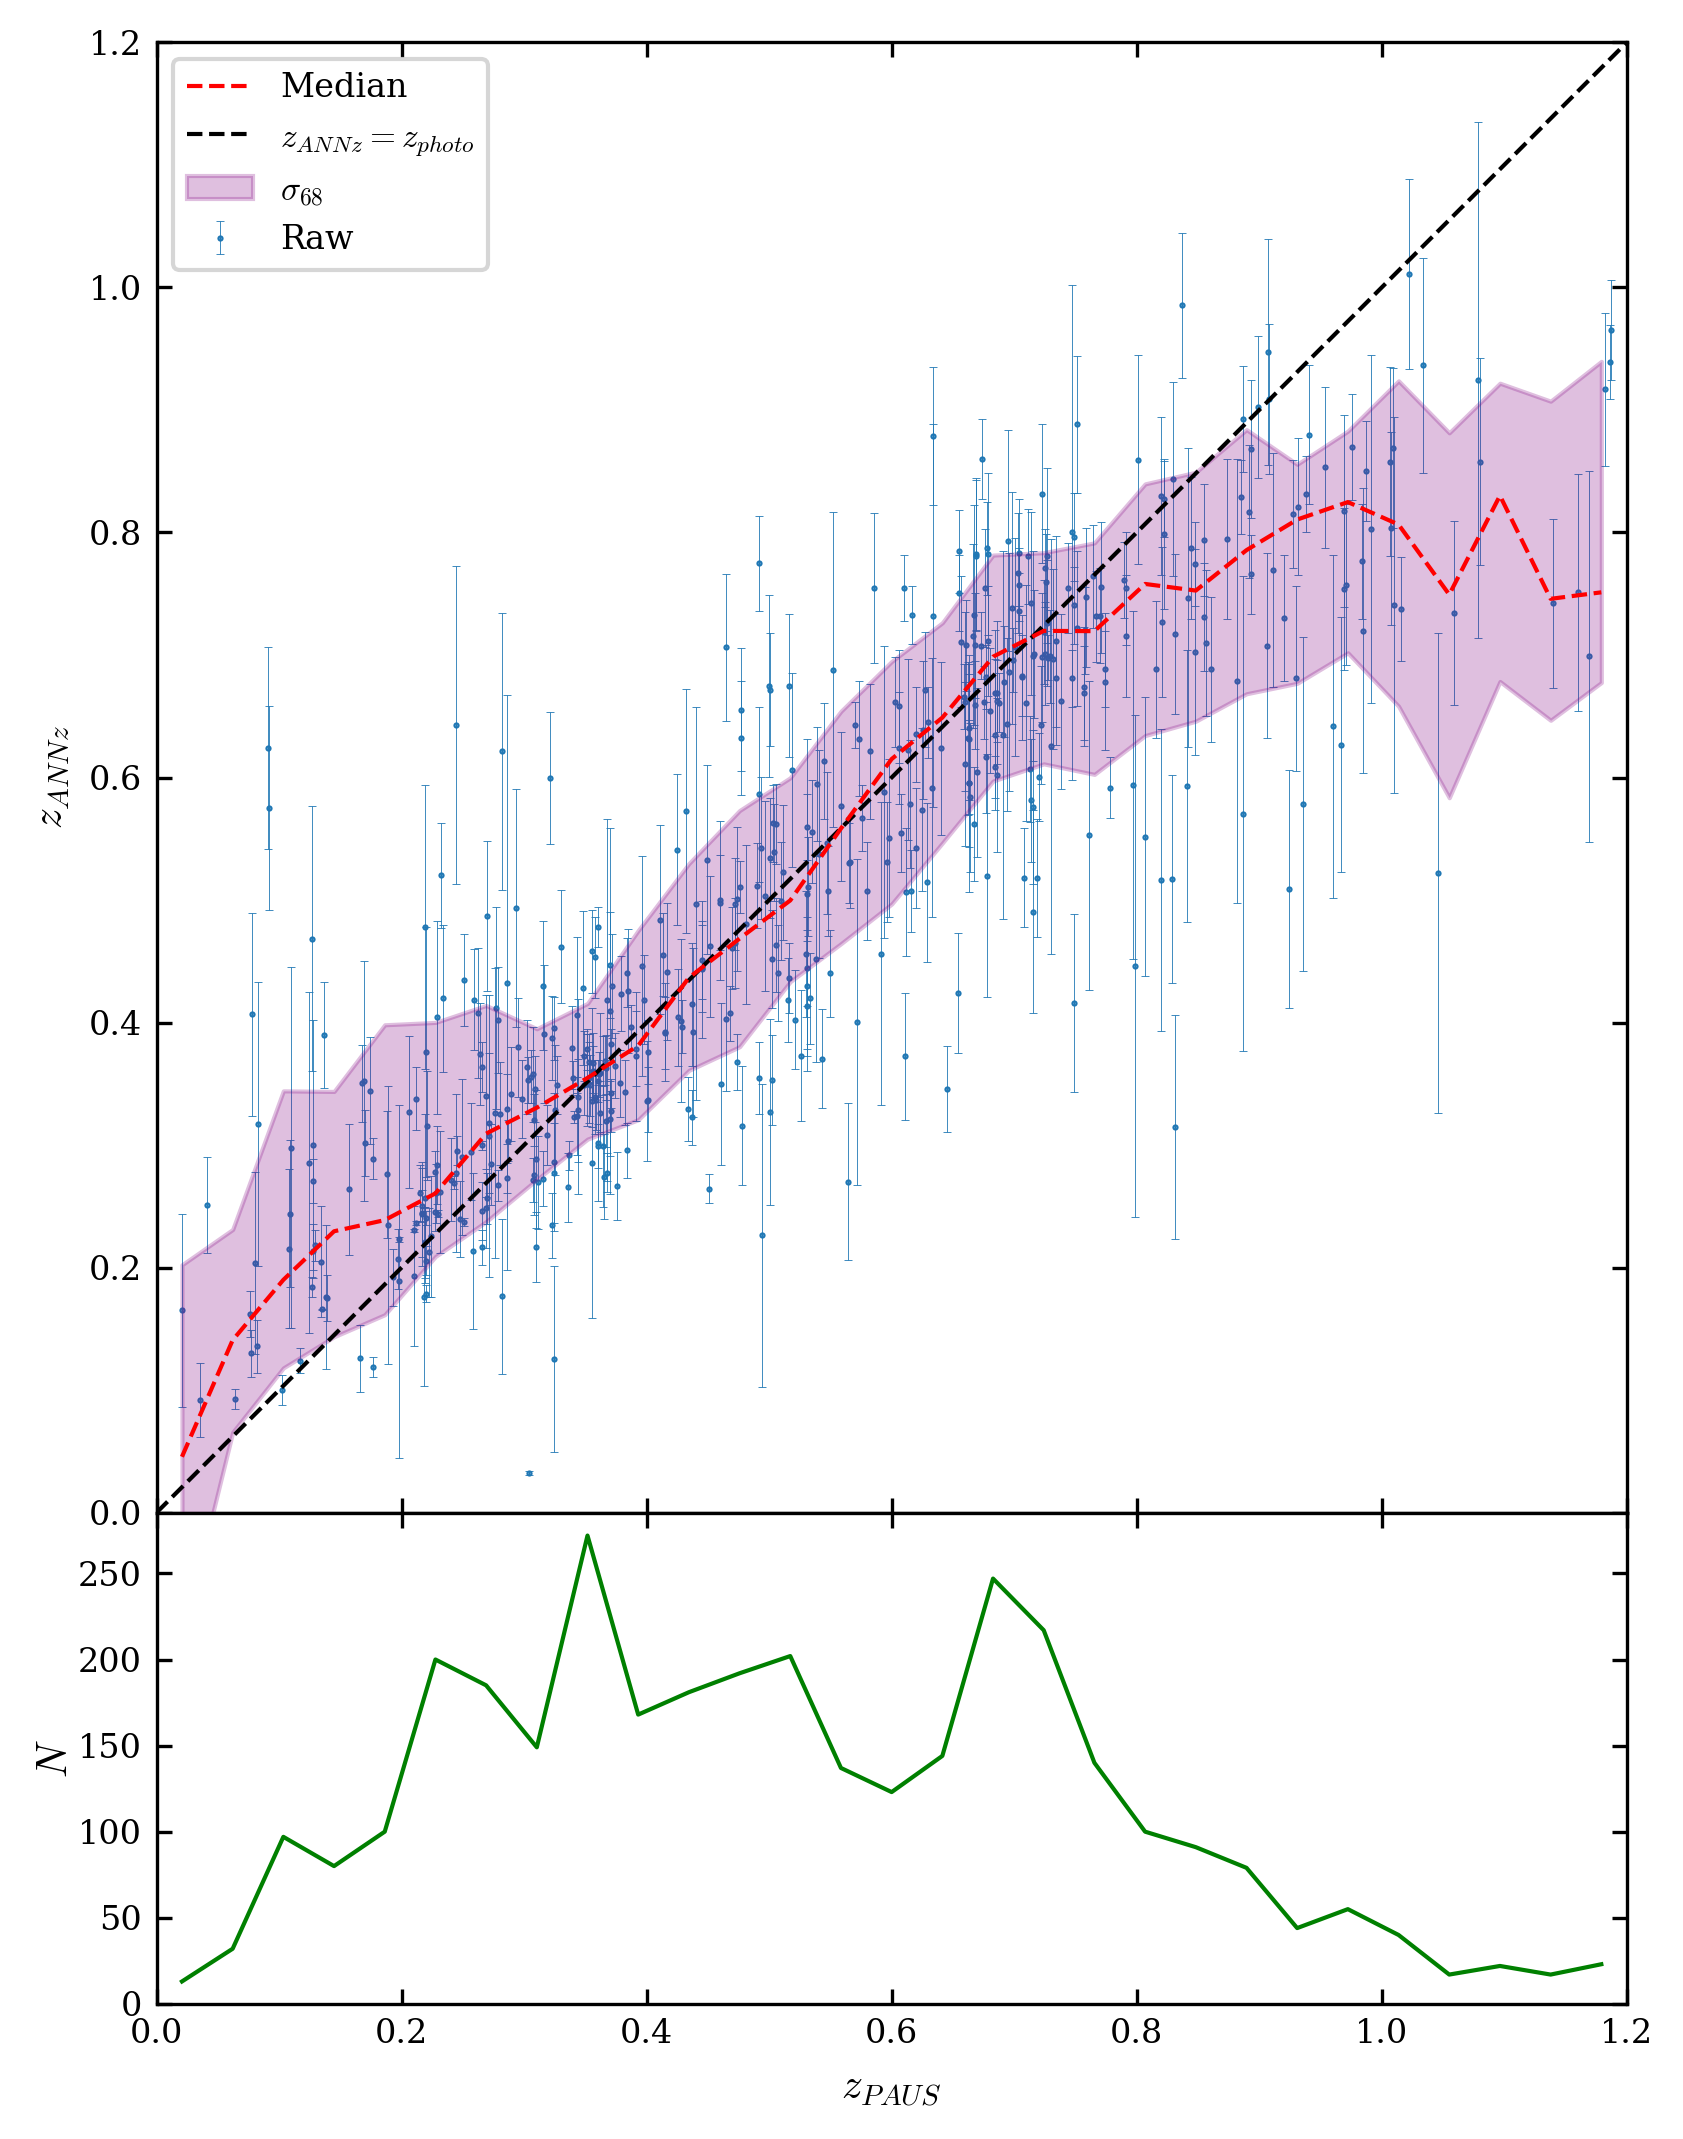

In [11]:
# ML_DATA = pd.read_csv('../../ML runs/PAUS_advanced3/regres/eval_nFile0/ANNZ_randomReg_0000.csv',header=0)
# ML_DATA
# print(ML_DATA.shape)
N_points = 250
# indices = np.random.choice(ML_DATA.shape[0],N_points,replace=False)

min_bin, max_bin, N_bin = 0.0,1.2,30
bins = np.linspace(min_bin, max_bin, N_bin)
meds,edge,counts = scipy.stats.binned_statistic(z_paus,z_annz,'median',bins=bins)
lbs = scipy.stats.binned_statistic(z_paus,z_annz,lb68,bins)[0]
ubs = scipy.stats.binned_statistic(z_paus,z_annz,ub68,bins)[0]


factor = latex_textwidth/72#*0.5
# fig = plt.figure(figsize=(factor*1.2,factor),dpi=300)
fig, (ax1,ax2) = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3, 1]},figsize=(1*factor,1.37*factor),dpi=300,sharex=True)

ax1.errorbar(z_paus.loc[indices],z_annz.loc[indices],yerr=z_annz_errors.loc[indices]\
             ,fmt='o',ms=0.5,linewidth=0.2,capsize=1,capthick=0.2,label='Raw'.format(N_points),zorder=1)
ax1.plot((bins[:-1]+bins[1:])/2,meds,'r--',label='Median',zorder=5,linewidth=1)
ax1.plot([0,1.2],[0,1.2],'k--',label=r'$z_{ANNz}=z_{photo}$',zorder=4,linewidth=1)
ax1.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.25,zorder=3,label=r'$\sigma_{68}$',color='purple')
ax2.set_xlabel(r'$z_{PAUS}$')
ax1.set_ylabel(r'$z_{ANNz}$')
ax1.legend(fontsize=8)
ax1.set_xlim(0.0,1.2)
ax1.set_ylim(0.0,1.2)
ax1.set_aspect('equal')

# ax2 = plt.subplot(212)
unique, counted = np.unique(counts, return_counts=True)
# print(unique,'\n',counted)
# ax2.plot((bins[:-1]+bins[1:])/2,counted/(max_bin-min_bin)*N_bin,'g-',zorder=5,linewidth=1)
# ax2.set_ylabel('$n$') #object density
ax2.plot((bins[:-1]+bins[1:])/2,counted,'g-',zorder=5,linewidth=1)
ax2.set_ylabel('$N$')
ax2.yaxis.labelpad=0.5


fig.subplots_adjust(hspace=0)
# custom_SAVEFIG('ML')

plt.show()

# ANNz run performance (25 BDTs, weighting, SPEC_advanced3)

In [12]:
ML_DATA = pd.read_csv('../../ML runs/SPEC_advanced3/ANNZ_randomReg_0000.csv',header=0)
z_annz = ML_DATA['F:ANNZ_best']
z_paus = ML_DATA['F:zspec']
z_annz_errors = ML_DATA['F:ANNZ_best_err']
# z_annz_errors = ML_DATA['F:ANNZ_best_err']

# ML_input = pd.read_csv('../../Data/ANNz_data5b.csv',header=0)

error = z_annz - z_paus
normed_error = error / (1+z_paus)

outliers_idx = abs(normed_error) > 0.15
out_perc = outliers_idx.sum()/outliers_idx.size *100

print("\
Mean normed error                             = {:1.2e} \n\
st. dev of normed error                       = {:.3f}\n\
Percentage of 'catastrophic' outliers         = {:.3f}%\n\
half width of 68th percentile of normed error = {:.3f}"\
.format(normed_error.mean(),np.std(normed_error),out_perc,(ub68(normed_error)-lb68(normed_error))/2))

Mean normed error                             = 7.58e-03 
st. dev of normed error                       = 0.084
Percentage of 'catastrophic' outliers         = 6.452%
half width of 68th percentile of normed error = 0.053


/home/andrew/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


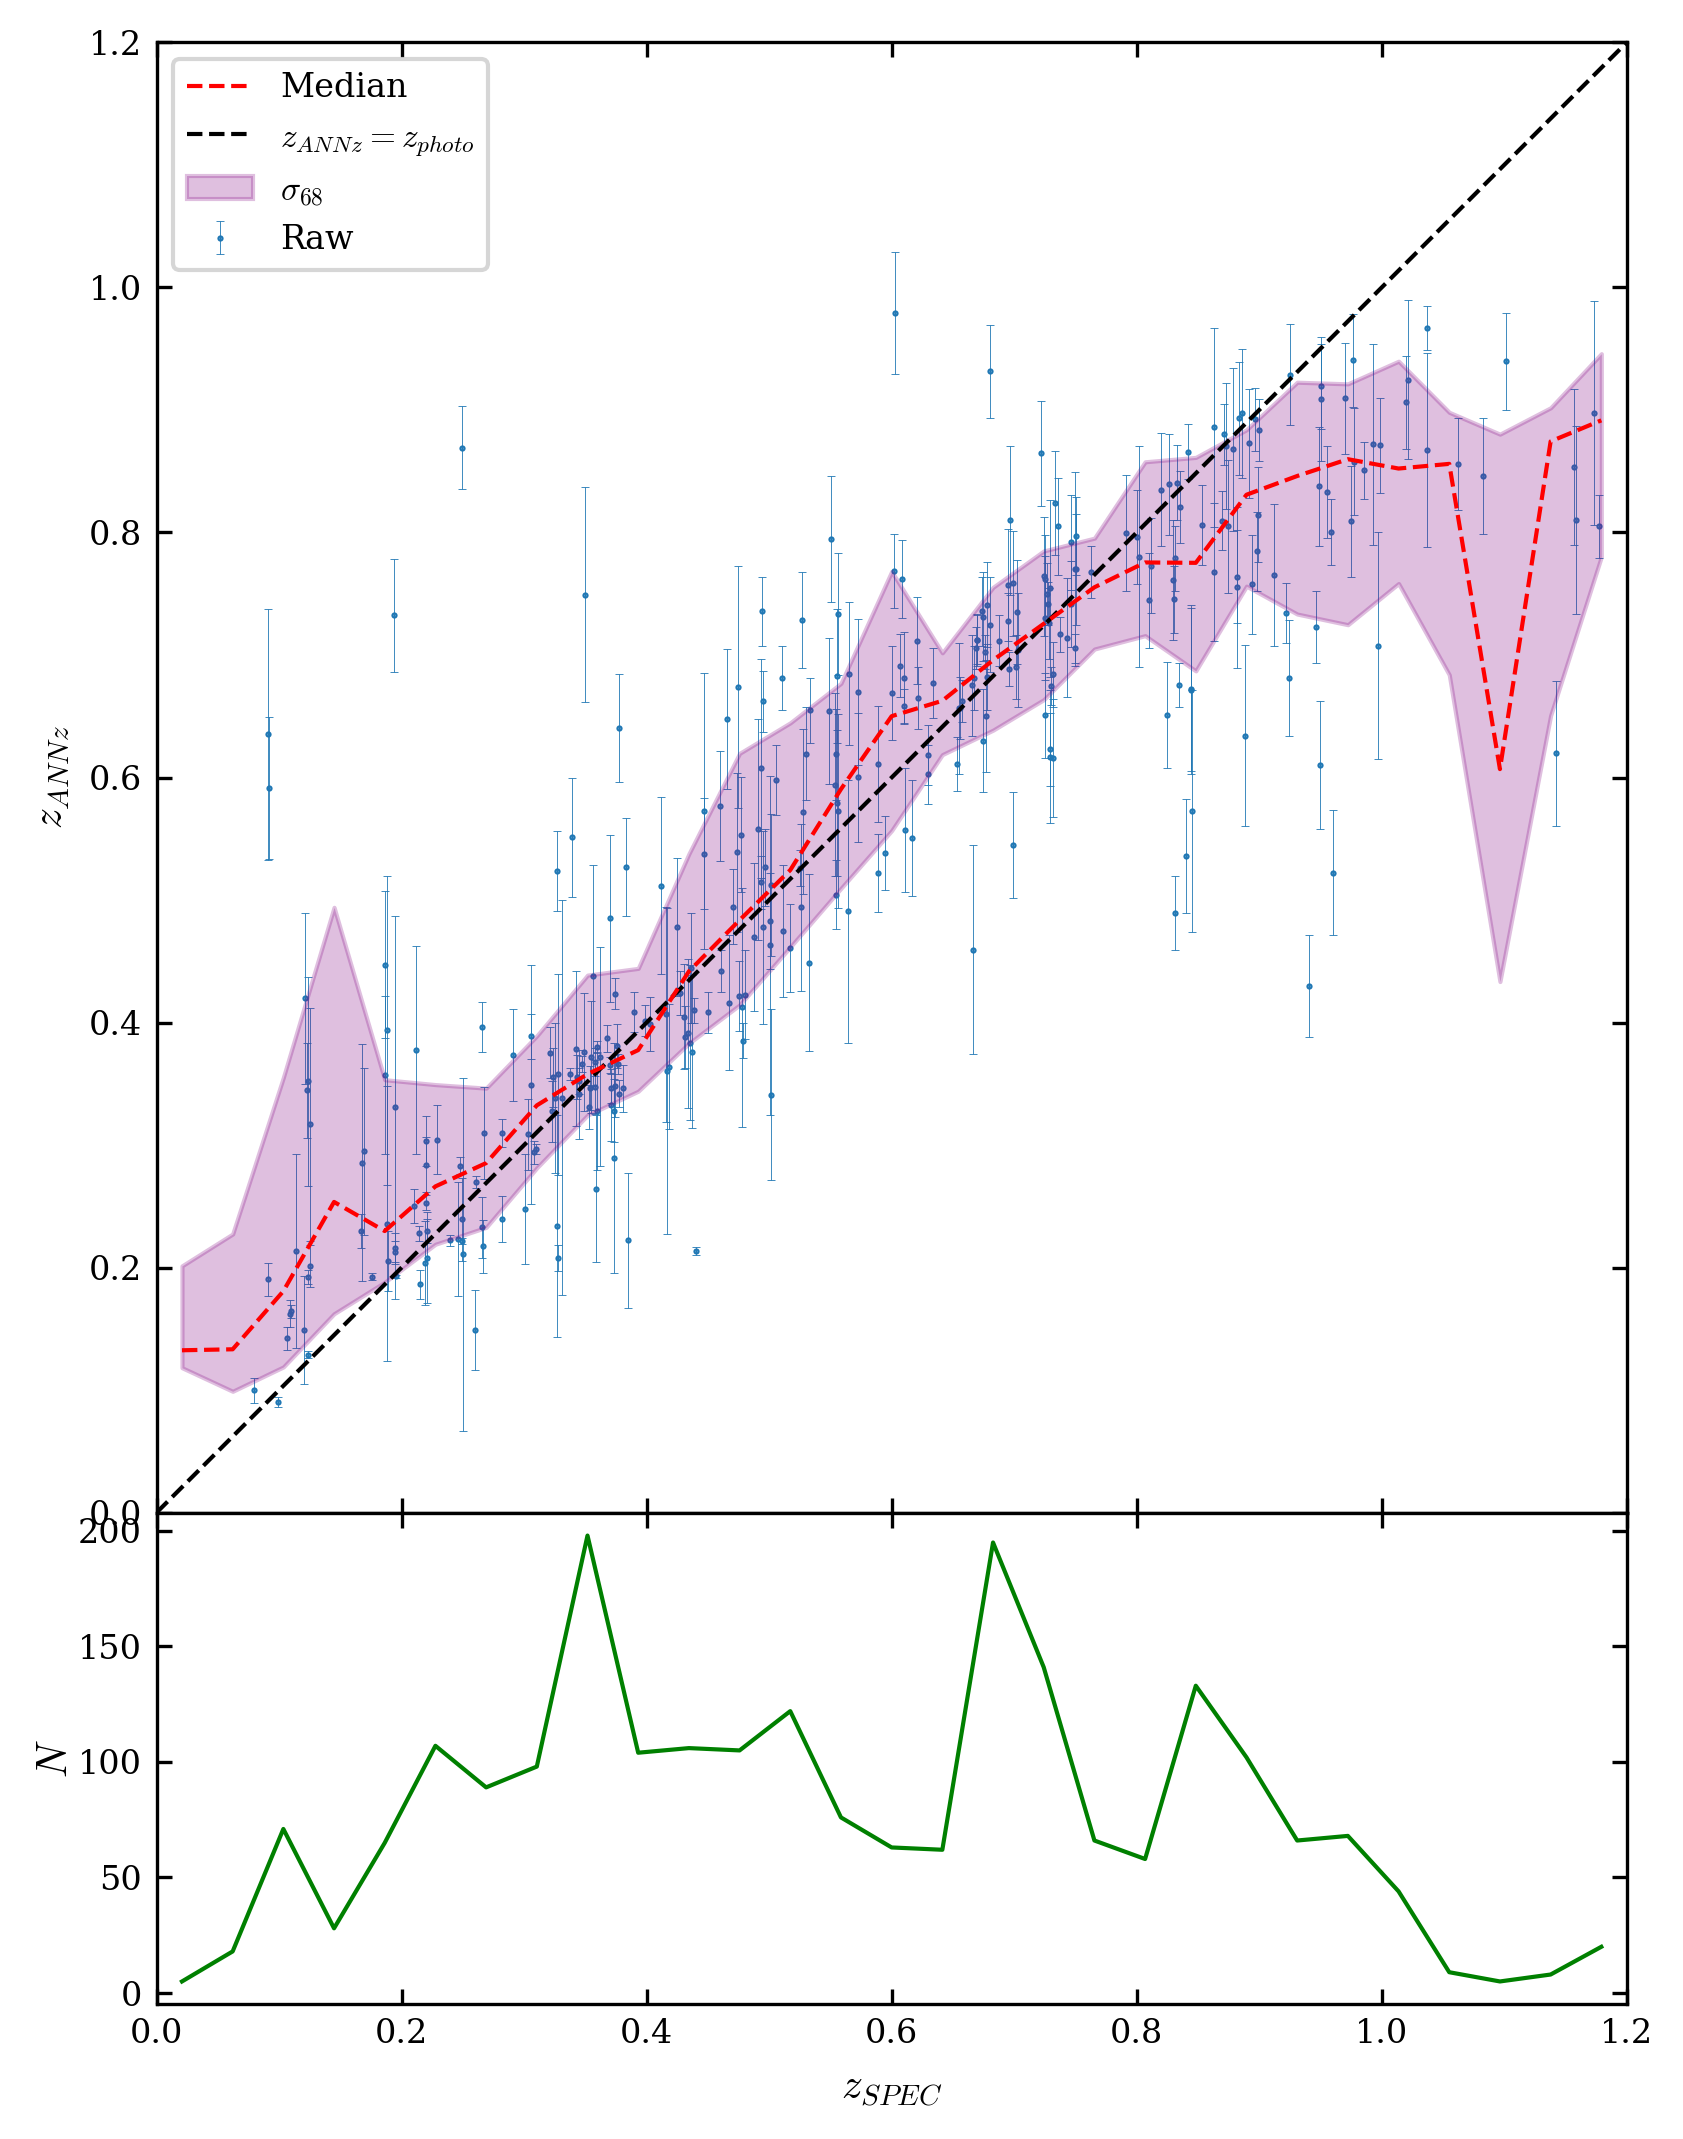

In [13]:
# ML_DATA = pd.read_csv('../../ML runs/PAUS_advanced3/regres/eval_nFile0/ANNZ_randomReg_0000.csv',header=0)
# ML_DATA
# print(ML_DATA.shape)
N_points = 250
# indices = np.random.choice(ML_DATA.shape[0],N_points,replace=False)

min_bin, max_bin, N_bin = 0.0,1.2,30
bins = np.linspace(min_bin, max_bin, N_bin)
meds,edge,counts = scipy.stats.binned_statistic(z_paus,z_annz,'median',bins=bins)
lbs = scipy.stats.binned_statistic(z_paus,z_annz,lb68,bins)[0]
ubs = scipy.stats.binned_statistic(z_paus,z_annz,ub68,bins)[0]


factor = latex_textwidth/72#*0.5
# fig = plt.figure(figsize=(factor*1.2,factor),dpi=300)
fig, (ax1,ax2) = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3, 1]},figsize=(1*factor,1.37*factor),dpi=300,sharex=True)

ax1.errorbar(z_paus.loc[indices],z_annz.loc[indices],yerr=z_annz_errors.loc[indices]\
             ,fmt='o',ms=0.5,linewidth=0.2,capsize=1,capthick=0.2,label='Raw'.format(N_points),zorder=1)
ax1.plot((bins[:-1]+bins[1:])/2,meds,'r--',label='Median',zorder=5,linewidth=1)
ax1.plot([0,1.2],[0,1.2],'k--',label=r'$z_{ANNz}=z_{photo}$',zorder=4,linewidth=1)
ax1.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.25,zorder=3,label=r'$\sigma_{68}$',color='purple')
ax2.set_xlabel(r'$z_{SPEC}$')
ax1.set_ylabel(r'$z_{ANNz}$')
ax1.legend(fontsize=8)
ax1.set_xlim(0.0,1.2)
ax1.set_ylim(0.0,1.2)
ax1.set_aspect('equal')

# ax2 = plt.subplot(212)
unique, counted = np.unique(counts, return_counts=True)
# print(unique,'\n',counted)
# ax2.plot((bins[:-1]+bins[1:])/2,counted/(max_bin-min_bin)*N_bin,'g-',zorder=5,linewidth=1)
# ax2.set_ylabel('$n$') #object density
ax2.plot((bins[:-1]+bins[1:])/2,counted,'g-',zorder=5,linewidth=1)
ax2.set_ylabel('$N$')
ax2.yaxis.labelpad=0.5


fig.subplots_adjust(hspace=0)
# custom_SAVEFIG('ML')



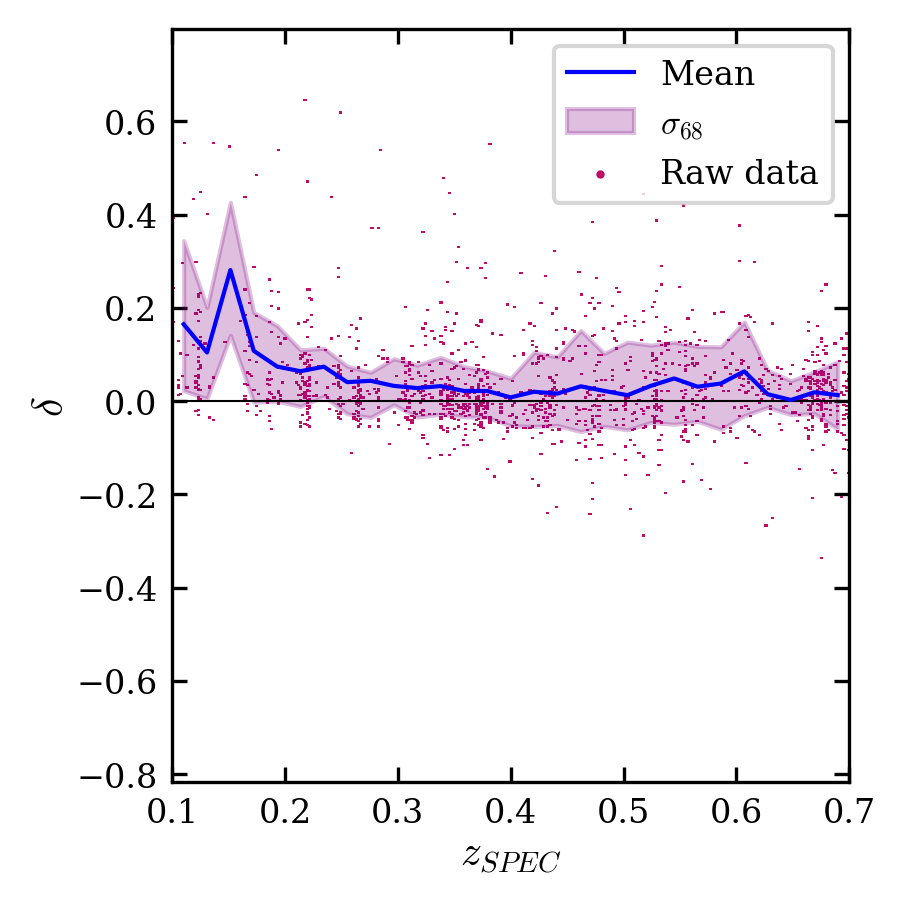

In [14]:


bins = np.linspace(0.1,0.7,30)
mean,edge,counts = scipy.stats.binned_statistic(z_paus,error,'mean',bins=bins)

lbs, edge, counts = scipy.stats.binned_statistic(z_paus,error,lb68,bins=bins)
ubs, edge, counts = scipy.stats.binned_statistic(z_paus,error,ub68,bins=bins)




factor = latex_textwidth/72*0.5
plt.figure(figsize=(factor,factor),dpi=300)
# plt.scatter(z_paus.loc[indices],normed_error.loc[indices],s=0.1)
pixs = 600
bounds = [0,0.9,1e6]
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
# hist = plt.hist2d(z_paus.loc[:],normed_error.loc[:],[pixs,pixs],cmap='ClearPurple',zorder=2)
plt.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.25,zorder=3,label=r'$\sigma_{68}$',color='purple')
hist = plt.hist2d(z_paus,error,[pixs,pixs],norm=norm,cmap='ClearPurple',zorder=2)
# norm=matplotlib.colors.LogNorm()
plt.plot((bins[1:]+bins[:-1])/2,mean,'b-',zorder=10,label='Mean')
plt.axhline(linewidth=0.5,zorder=3,color='black')
plt.ylabel('$\delta$')
plt.xlabel('$z_{SPEC}$')

plt.scatter([-1],[-1],s=1,color='#c10968',label='Raw data')
plt.xlim(0.1,0.7)
# plt.ylim(-0.5,0.9)

# plt.colorbar(hist[3])
plt.legend()
plt.tight_layout()
plt.gca().xaxis.labelpad = 1
plt.gca().yaxis.labelpad = 1
# custom_SAVEFIG('ML_ERROR')
plt.show()

# ANNz run performance (25 MLMs, ANN&BDT, SPEC_advanced4)

In [15]:
ML_DATA = pd.read_csv('../../ML runs/SPEC_advanced4/ANNZ_randomReg_0000.csv',header=0)
z_annz = ML_DATA['F:ANNZ_best']
z_paus = ML_DATA['F:zspec']
z_annz_errors = ML_DATA['F:ANNZ_best_err']
# z_annz_errors = ML_DATA['F:ANNZ_best_err']

# ML_input = pd.read_csv('../../Data/ANNz_data5b.csv',header=0)

error = z_annz - z_paus
normed_error = error / (1+z_paus)

outliers_idx = abs(normed_error) > 0.15
out_perc = outliers_idx.sum()/outliers_idx.size *100

print("\
Mean normed error                             = {:1.2e} \n\
st. dev of normed error                       = {:.3f}\n\
Percentage of 'catastrophic' outliers         = {:.3f}%\n\
half width of 68th percentile of normed error = {:.3f}"\
.format(normed_error.mean(),np.std(normed_error),out_perc,(ub68(normed_error)-lb68(normed_error))/2))

Mean normed error                             = 6.60e-03 
st. dev of normed error                       = 0.076
Percentage of 'catastrophic' outliers         = 4.928%
half width of 68th percentile of normed error = 0.052


/home/andrew/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


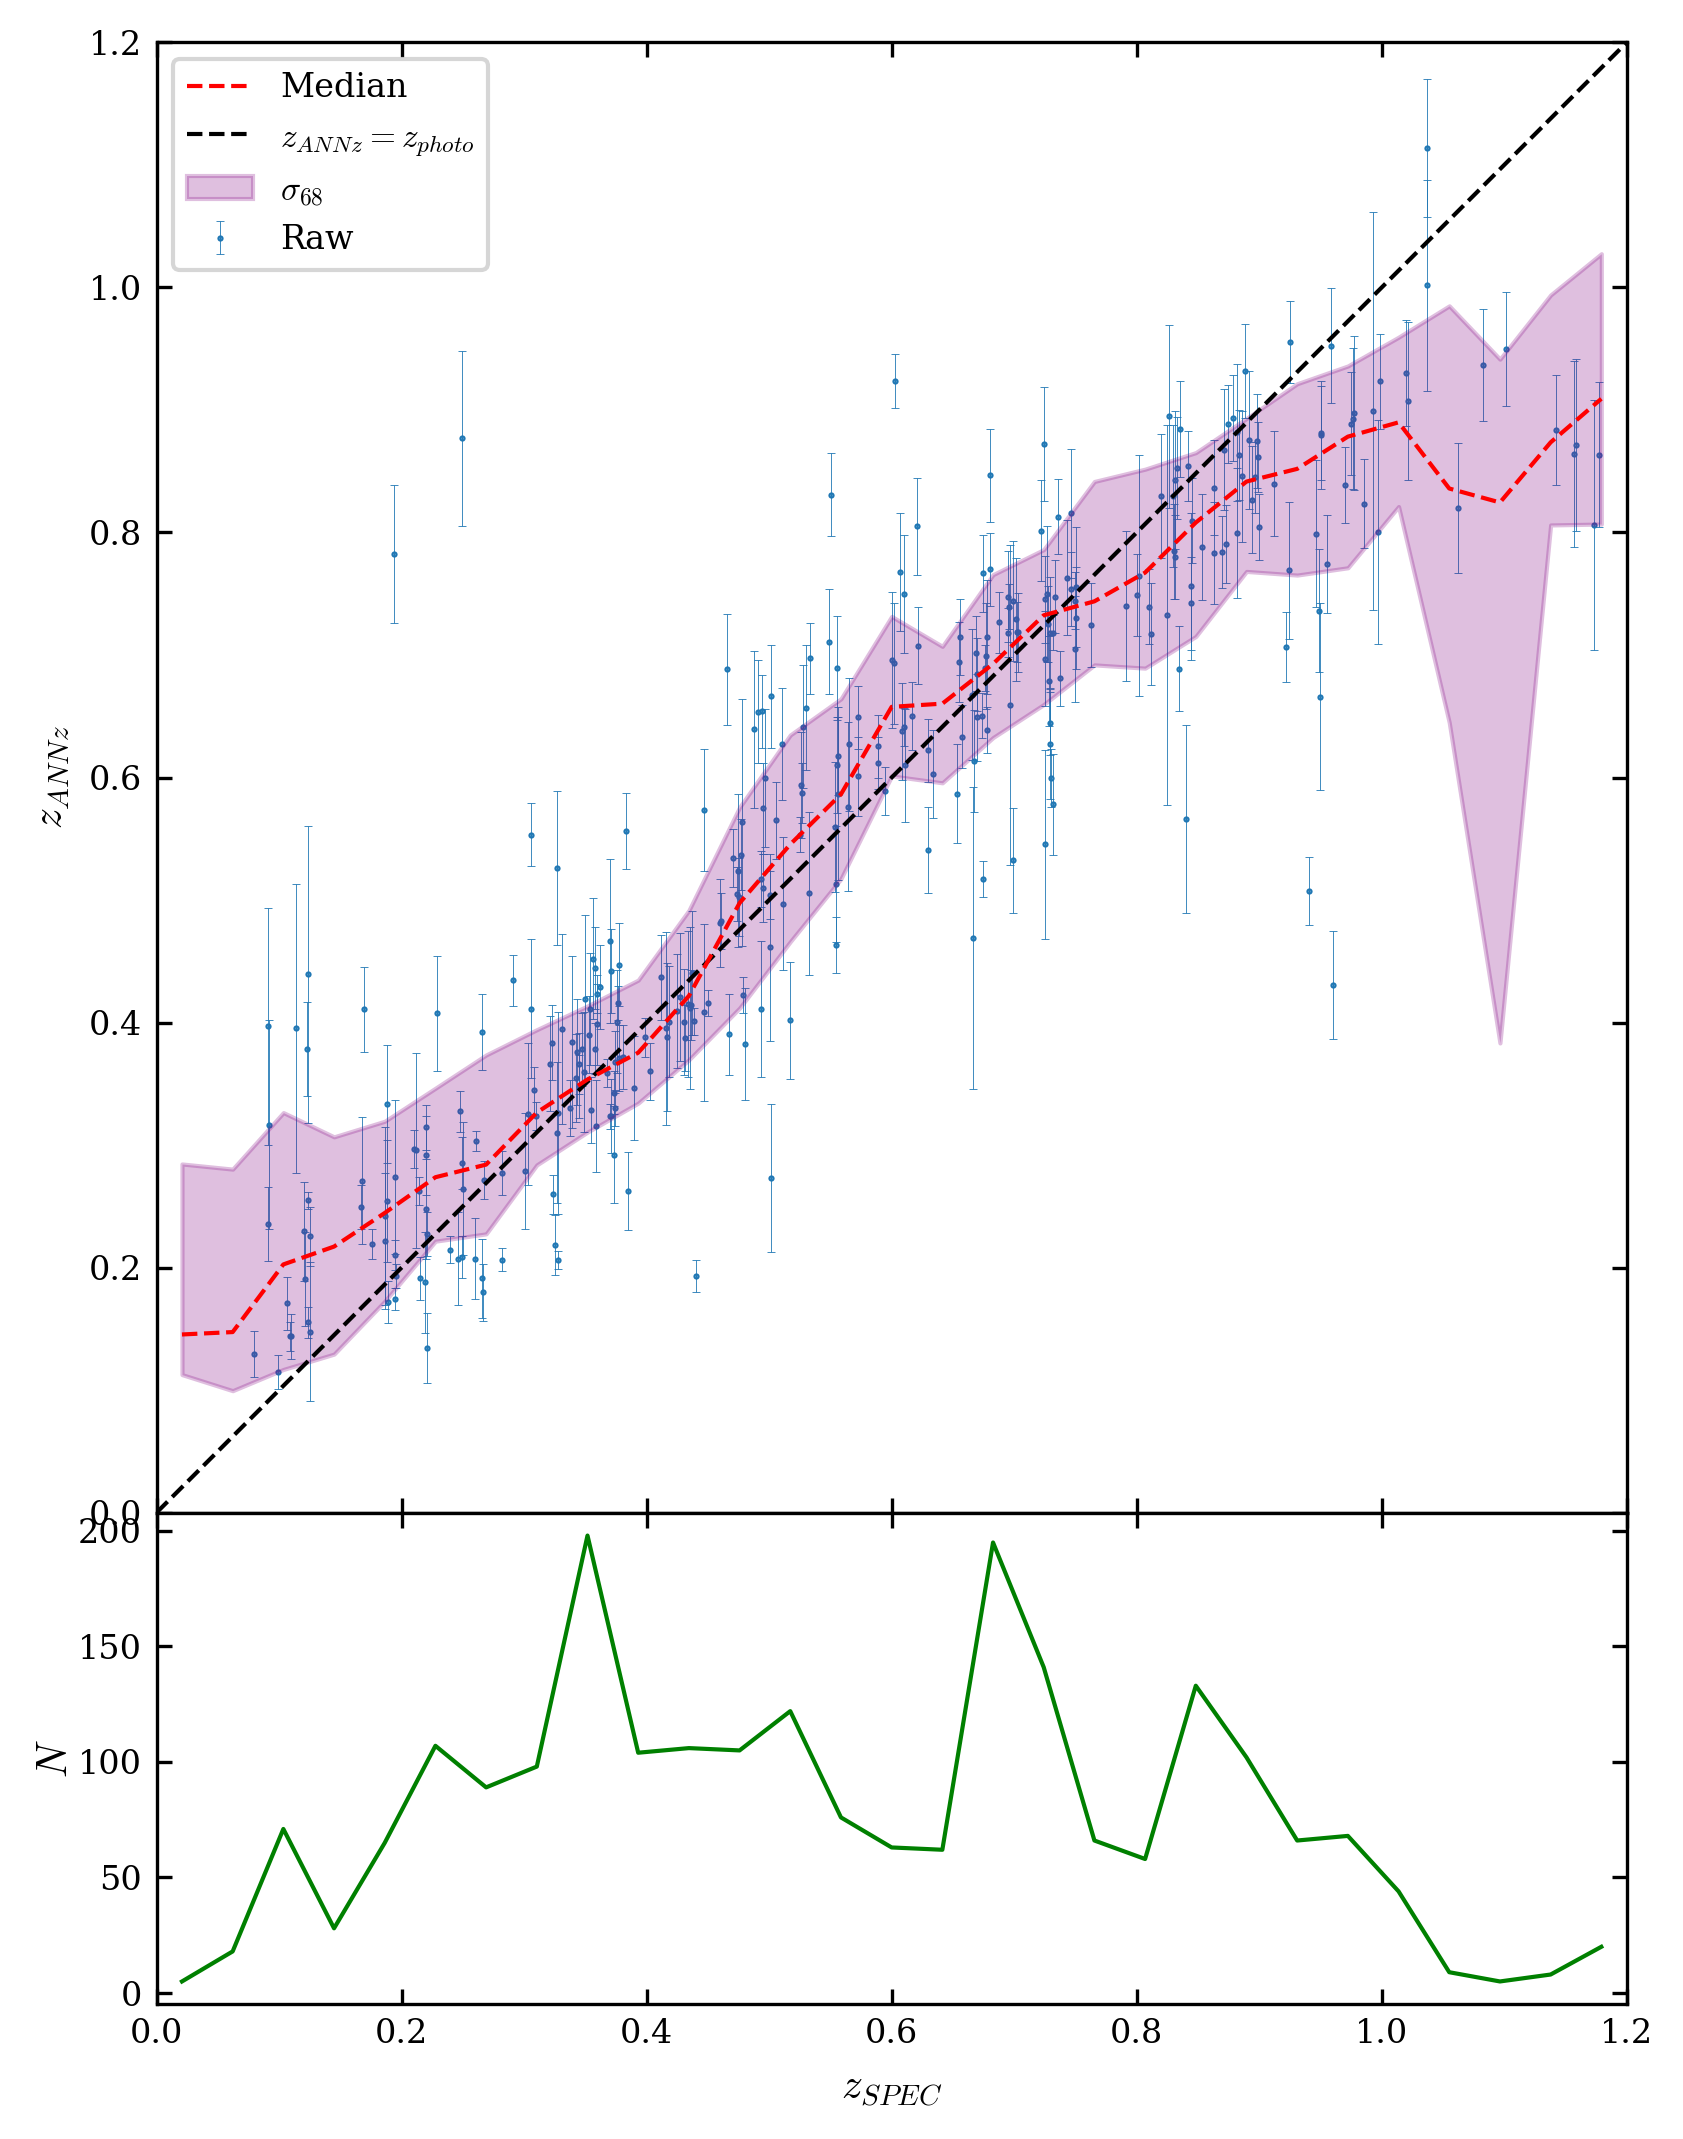

In [16]:
# ML_DATA = pd.read_csv('../../ML runs/PAUS_advanced3/regres/eval_nFile0/ANNZ_randomReg_0000.csv',header=0)
# ML_DATA
# print(ML_DATA.shape)
N_points = 250
# indices = np.random.choice(ML_DATA.shape[0],N_points,replace=False)

min_bin, max_bin, N_bin = 0.0,1.2,30
bins = np.linspace(min_bin, max_bin, N_bin)
meds,edge,counts = scipy.stats.binned_statistic(z_paus,z_annz,'median',bins=bins)
lbs = scipy.stats.binned_statistic(z_paus,z_annz,lb68,bins)[0]
ubs = scipy.stats.binned_statistic(z_paus,z_annz,ub68,bins)[0]


factor = latex_textwidth/72#*0.5
# fig = plt.figure(figsize=(factor*1.2,factor),dpi=300)
fig, (ax1,ax2) = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3, 1]},figsize=(1*factor,1.37*factor),dpi=300,sharex=True)

ax1.errorbar(z_paus.loc[indices],z_annz.loc[indices],yerr=z_annz_errors.loc[indices]\
             ,fmt='o',ms=0.5,linewidth=0.2,capsize=1,capthick=0.2,label='Raw'.format(N_points),zorder=1)
ax1.plot((bins[:-1]+bins[1:])/2,meds,'r--',label='Median',zorder=5,linewidth=1)
ax1.plot([0,1.2],[0,1.2],'k--',label=r'$z_{ANNz}=z_{photo}$',zorder=4,linewidth=1)
ax1.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.25,zorder=3,label=r'$\sigma_{68}$',color='purple')
ax2.set_xlabel(r'$z_{SPEC}$')
ax1.set_ylabel(r'$z_{ANNz}$')
ax1.legend(fontsize=8)
ax1.set_xlim(0.0,1.2)
ax1.set_ylim(0.0,1.2)
ax1.set_aspect('equal')

# ax2 = plt.subplot(212)
unique, counted = np.unique(counts, return_counts=True)
# print(unique,'\n',counted)
# ax2.plot((bins[:-1]+bins[1:])/2,counted/(max_bin-min_bin)*N_bin,'g-',zorder=5,linewidth=1)
# ax2.set_ylabel('$n$') #object density
ax2.plot((bins[:-1]+bins[1:])/2,counted,'g-',zorder=5,linewidth=1)
ax2.set_ylabel('$N$')
ax2.yaxis.labelpad=0.5


fig.subplots_adjust(hspace=0)
# custom_SAVEFIG('ML')



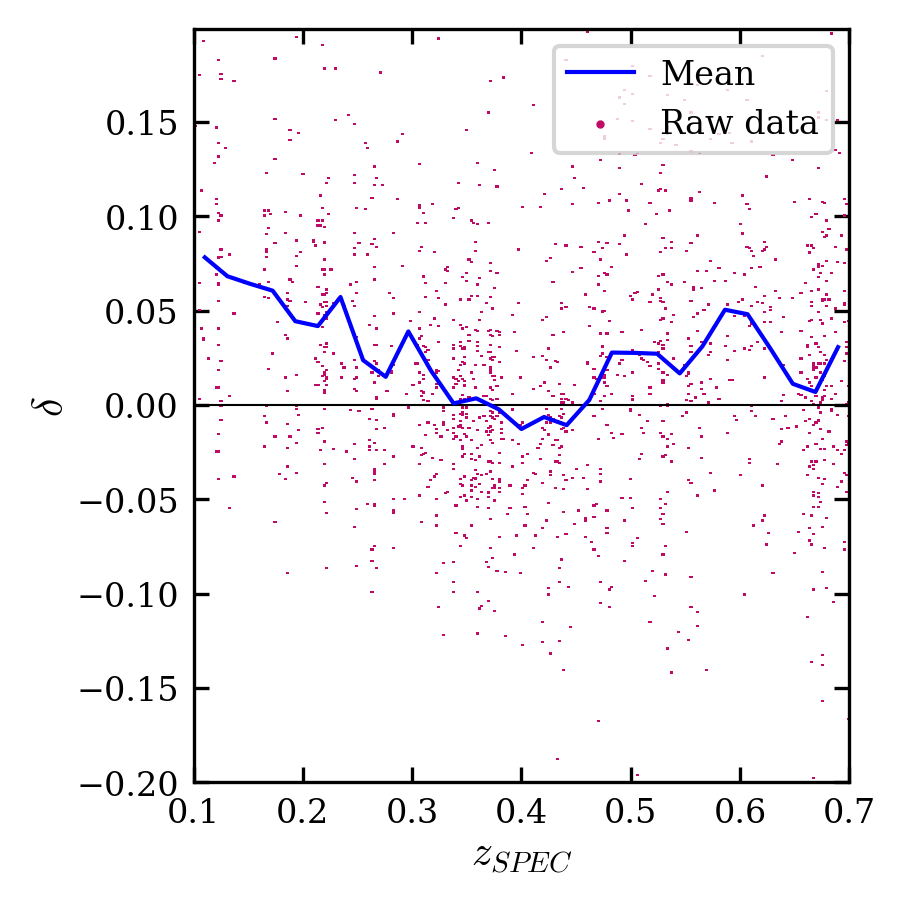

In [17]:


bins = np.linspace(0.1,0.7,30)

error_lims = [-0.2,0.2]
mask = (error <= error_lims[1]) & (error>=error_lims[0])
z_paus, error = z_paus.loc[mask], error.loc[mask]

mean,edge,counts = scipy.stats.binned_statistic(z_paus,error,'mean',bins=bins)



factor = latex_textwidth/72*0.5
plt.figure(figsize=(factor,factor),dpi=300)
# plt.scatter(z_paus.loc[indices],normed_error.loc[indices],s=0.1)
pixs = 600
bounds = [0,0.9,1e6]
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
# hist = plt.hist2d(z_paus.loc[:],normed_error.loc[:],[pixs,pixs],cmap='ClearPurple',zorder=2)

hist = plt.hist2d(z_paus,error,[pixs,pixs],norm=norm,cmap='ClearPurple',zorder=2)
# norm=matplotlib.colors.LogNorm()
plt.plot((bins[1:]+bins[:-1])/2,mean,'b-',zorder=10,label='Mean')
plt.axhline(linewidth=0.5,zorder=3,color='black')
plt.ylabel('$\delta$')
plt.xlabel('$z_{SPEC}$')

plt.scatter([-1],[-1],s=1,color='#c10968',label='Raw data')
plt.xlim(0.1,0.7)
# plt.ylim(-0.5,0.9)

# plt.colorbar(hist[3])
plt.legend()
plt.tight_layout()
plt.gca().xaxis.labelpad = 1
plt.gca().yaxis.labelpad = 1
# custom_SAVEFIG('ML_ERROR')
plt.show()

In [19]:
ML_DATA.rename(columns={'F:ref_id':'ref_id'},inplace=True)

In [23]:
combined = data.merge(ML_DATA, on=['ref_id'])

In [24]:
combined.columns.values

array(['ref_id', 'zb', 'odds', 'pz_width', 'zb_mean', 'chi2', 'n_band',
       'ebv', 'qz', 'best_run', 'production_id', 'paudm_id', 'ra', 'dec',
       'zp_gal', 'zl68_gal', 'zu68_gal', 'zl99_gal', 'zu99_gal', 'zp_sec',
       'dchi', 'imag', 'ei', 'i_auto', 'nbfilt', 'mod_gal', 'type',
       'umag', 'bmag', 'vmag', 'gmag', 'rmag', 'zmag', 'icmag', 'jmag',
       'kmag', 'mv', 'ebv_gal', 'ebv_int', 'acs_a_image', 'acs_b_image',
       'acs_theta_image', 'acs_mag_auto', 'acs_magerr_auto', 'zspec',
       'conf', 'f814w', 'zfits', 'r50', 'sersic_n_gim2d', '_col50',
       '_col54', 'n_coadd', 'run', '_col57', 'band0', 'band1', 'band2',
       'band3', 'band4', 'band5', 'band6', 'band7', 'band8', 'band9',
       'band10', 'band11', 'band12', 'band13', 'band14', 'band15',
       'band16', 'band17', 'band18', 'band19', 'band20', 'band21',
       'band22', 'band23', 'band24', 'band25', 'band26', 'band27',
       'band28', 'band29', 'band30', 'band31', 'band32', 'band33',
       'band34', '

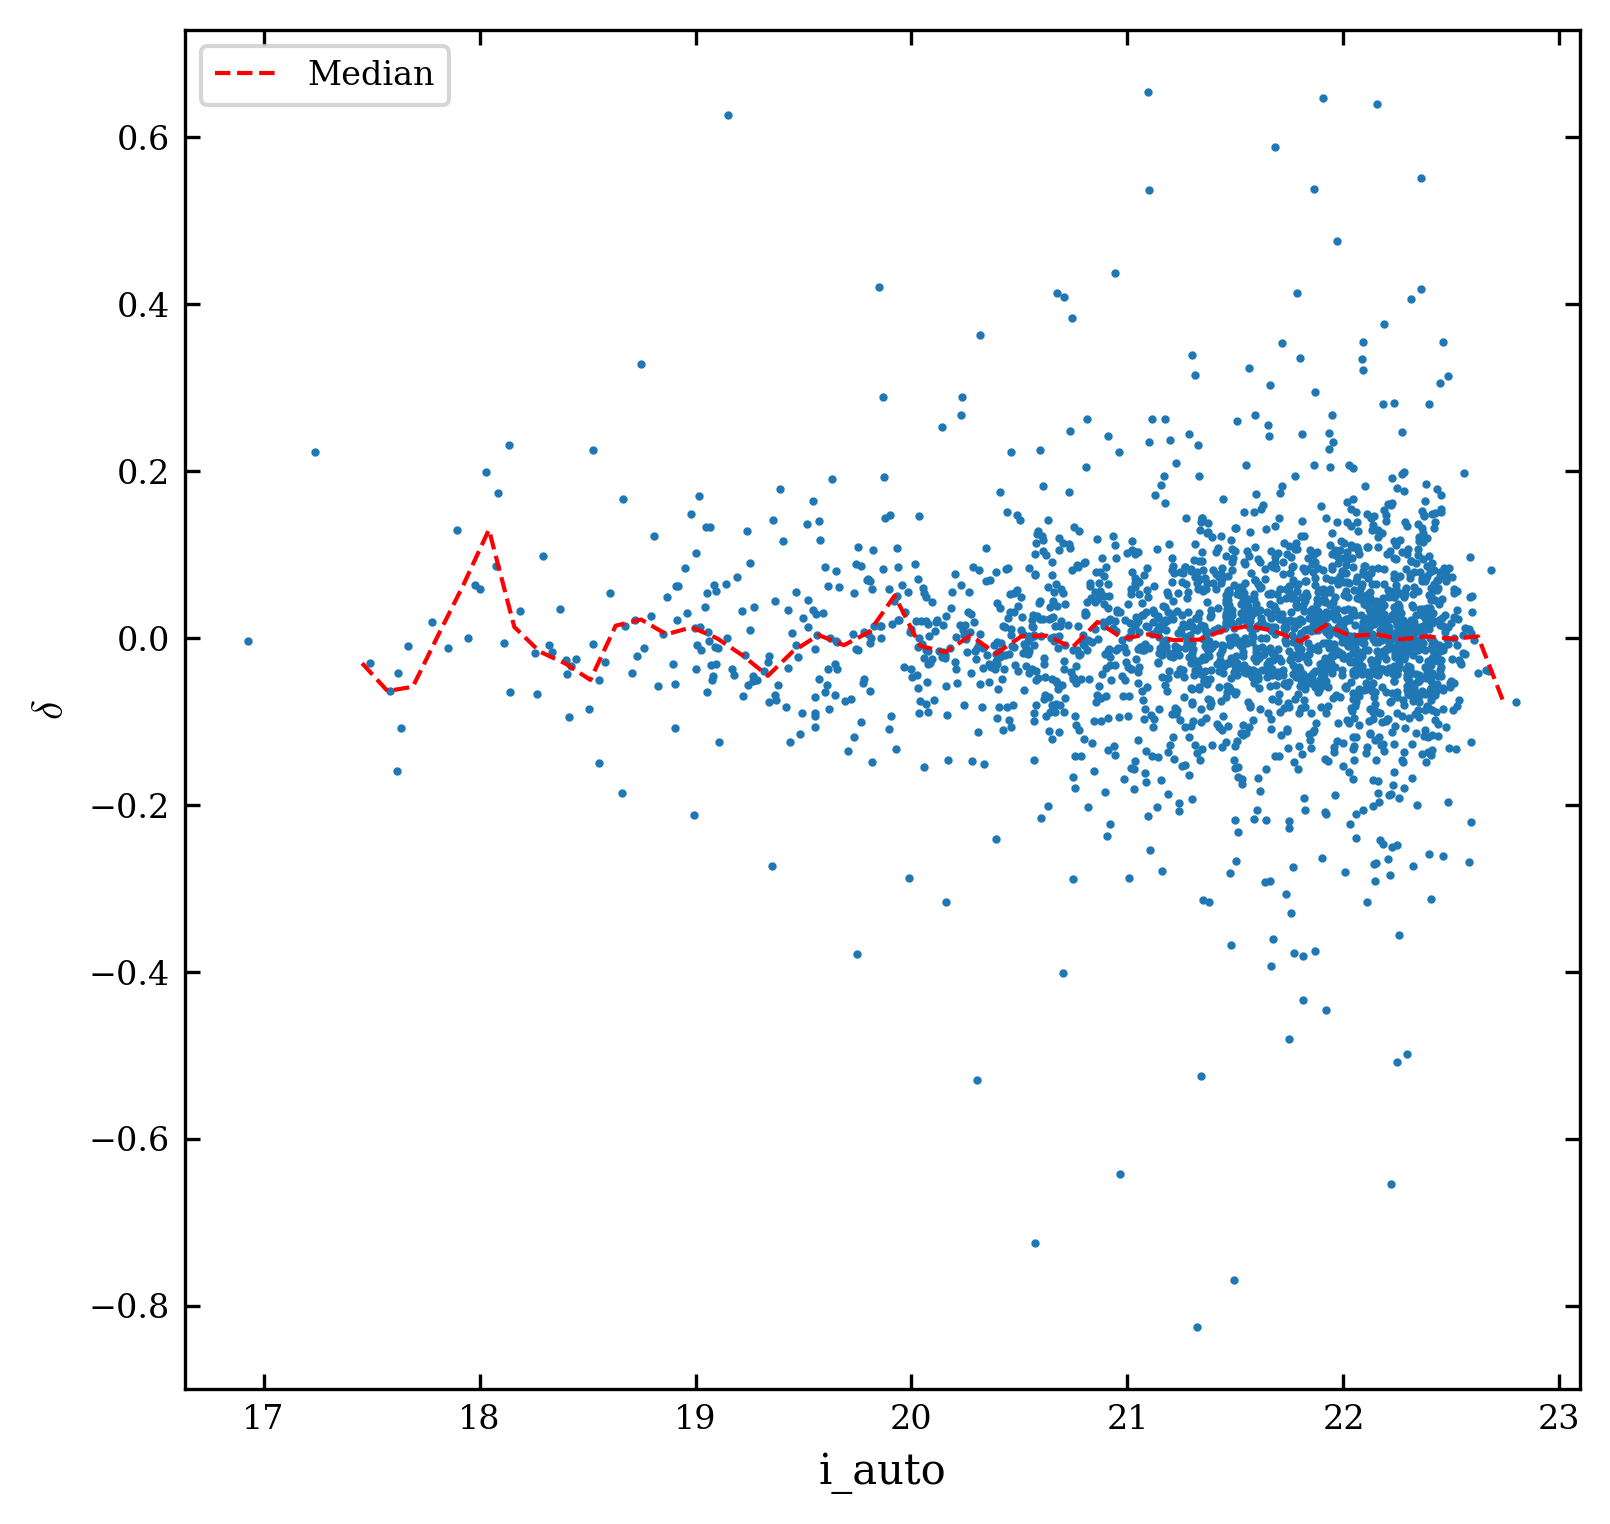

In [29]:
medians,bins,a = scipy.stats.binned_statistic(combined['i_auto'],error,'median',bins=50)


plt.figure(dpi=300,figsize=(6,6))
plt.scatter(combined['i_auto'],error,s=1)
plt.plot((bins[1:]+bins[:-1])/2,medians,'r--',label='Median')

plt.xlabel('i_auto')
plt.ylabel(r'$\delta$')
plt.legend()
plt.show()

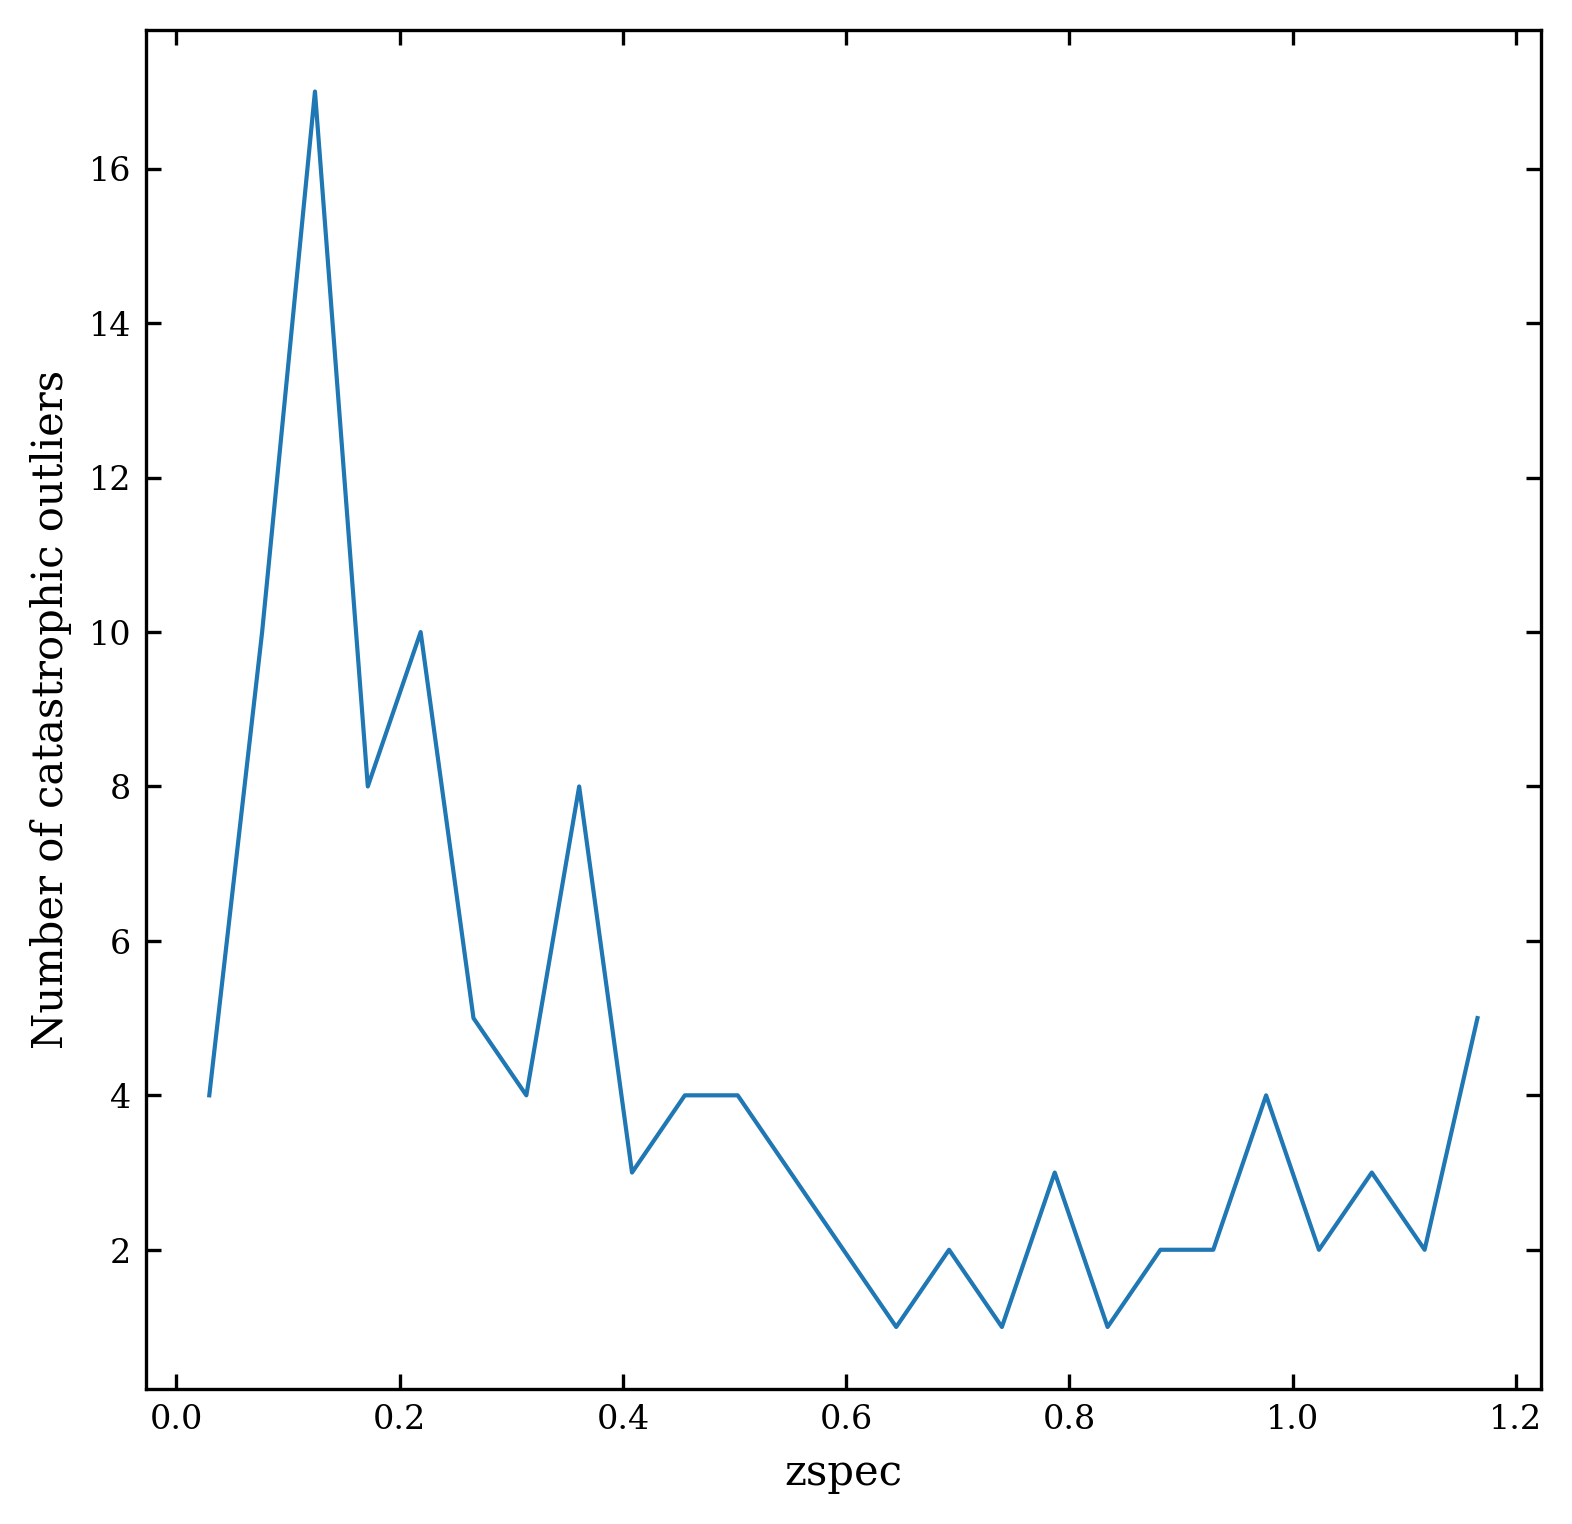

In [34]:
sums,bins,counts = scipy.stats.binned_statistic(z_paus,outliers_idx,"sum",bins=25)

plt.figure(dpi=300,figsize=(6,6))
plt.plot((bins[1:]+bins[:-1])/2,sums)
plt.xlabel("zspec")
plt.ylabel("Number of catastrophic outliers")

plt.show()